# __Modules import__

In [1]:
import os
import sys
import glob

import pandas as pd

import pyspark 
from pyspark import SparkConf,SparkContext
from pyspark.sql import SparkSession

from pyspark.sql import functions as F
from pyspark.sql.functions import udf
from pyspark.sql.functions import col, year, month, dayofweek, hour, weekofyear, dayofmonth,monotonically_increasing_id
from pyspark.sql.functions import expr, col
from pyspark.sql.functions import when
from pyspark.sql.functions import max
from pyspark.sql.window import Window
from pyspark.sql.functions import date_format
from pyspark.sql import Row

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

import configparser

import matplotlib.pyplot as plt

import matplotlib.pyplot as plt

import sys
print('python version : ', sys.version)




python version :  3.10.8 | packaged by conda-forge | (main, Nov 22 2022, 08:26:04) [GCC 10.4.0]


# __Parameters and AWS connections__

In [2]:
config = configparser.ConfigParser()    
config.read('dl_config.cfg')  

os.environ['AWS_ACCESS_KEY_ID'] = config.get('AWS', 'AWS_ACCESS_KEY_ID')
os.environ['AWS_SECRET_ACCESS_KEY'] = config.get('AWS', 'AWS_SECRET_ACCESS_KEY')

region = config.get('CLUSTER', 'AWS_REGION')

DL_BUCKET_NAME = config.get('S3_BUCKET','DL_BUCKET_NAME')
DL_BUCKET_OUTPUT_PREFIX = config.get('S3_BUCKET','DL_BUCKET_OUTPUT_PREFIX')
DL_BUCKET_INPUT_PREFIX = config.get('S3_BUCKET','DL_BUCKET_INPUT_PREFIX')

DL_BUCKET_SCRIPTS_FOLDER =  config.get('S3_BUCKET','DL_BUCKET_SCRIPTS_FOLDER')


['dl_config.cfg']

In [3]:
from pyspark.sql import SparkSession
def get_spark():
    spark = SparkSession.builder.master("local[4]").appName('SparkDelta') \
        .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension") \
        .config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog") \
        .config("spark.hadoop.fs.s3a.impl", "org.apache.hadoop.fs.s3a.S3AFileSystem") \
        .config("spark.jars.packages", 
                "io.delta:delta-core_2.12:1.1.0,"
                "org.apache.hadoop:hadoop-aws:3.2.2,"
                "com.amazonaws:aws-java-sdk-bundle:1.12.180") \
        .config('spark.hadoop.fs.s3a.aws.credentials.provider', 'org.apache.hadoop.fs.s3a.SimpleAWSCredentialsProvider')\
        .getOrCreate()
    return spark

spark = get_spark()
spark._jsc.hadoopConfiguration().set("com.amazonaws.services.s3.enableV4", "true")
spark._jsc.hadoopConfiguration().set("fs.s3a.impl", "org.apache.hadoop.fs.s3a.S3AFileSystem")
spark._jsc.hadoopConfiguration().set("fs.s3a.aws.credentials.provider","com.amazonaws.auth.InstanceProfileCredentialsProvider,com.amazonaws.auth.DefaultAWSCredentialsProviderChain")
spark._jsc.hadoopConfiguration().set("fs.AbstractFileSystem.s3a.impl", "org.apache.hadoop.fs.s3a.S3A")


In [4]:
spark.version

'3.3.1'

# __Read tables in staging area__

In [4]:
def input_data(folder_path, spark,DL_BUCKET_INPUT_PREFIX, file_type):
    """
    This function 
    :param folder_path:paty to the parquet files to check
    :param spark: spark connection object
    :param DL_BUCKET_INPUT_PREFIX: s3 path partial path fetched from dl_config,cfg
    :param file_type: 'parquet' or 'json'
    :return:the count of entries in the json or parquet file
    """
    path = os.path.join(DL_BUCKET_INPUT_PREFIX, folder_path).replace('s3', 's3a')
    if file_type == 'parquet':
        data =spark.read.parquet(path)
    if file_type == 'json':
        path = os.path.join(path,'*.json')
        data = spark.read.option("multiline","true").json(path)
    print("rows count :" , data.count())
    data = data.toPandas()
    print("columns : " ,data.columns)
    return data

In [16]:
tickers_historical_prices = input_data('markets_static_data/tickers_historical_prices/tickers_historical_prices.parquet', spark, DL_BUCKET_INPUT_PREFIX, 'parquet')
tickers_historical_prices.query("Interval=='1h'").head(1)
tickers_historical_prices.query("Interval=='1m'").head(2)
tickers_historical_prices.query("Interval=='1d'").head(1)

rows count : 24342
columns :  Index(['Datetime', 'Date', 'Ticker', 'Close', 'High', 'Low', 'Open', 'Volume',
       'Interval'],
      dtype='object')


,Datetime,Date,Ticker,Close,High,Low,Open,Volume,Interval
6144,2021-03-10 11:30:00,2021-03-10,AOS,64.959999,64.974998,64.480003,64.510002,94246.0,1h


,Datetime,Date,Ticker,Close,High,Low,Open,Volume,Interval
5034,2022-12-16 04:00:00,2022-12-16,MMM,122.08,122.30,121.37,122.30,0.0,1m
5035,2022-12-16 04:02:00,2022-12-16,MMM,122.22,122.23,122.22,122.23,0.0,1m


,Datetime,Date,Ticker,Close,High,Low,Open,Volume,Interval
0,2012-12-28 00:00:00,2012-12-28,AOS,13.36415,13.504621,13.240968,13.282029,1417600.0,1d


In [17]:
tickers_isin = input_data('markets_static_data/tickers_isin/tickers_isin.parquet', spark, DL_BUCKET_INPUT_PREFIX, 'parquet')
tickers_isin.head(1)

rows count : 2
columns :  Index(['isin', 'symbol'], dtype='object')


,isin,symbol
0,-,AOS


In [18]:
tickers_options = input_data('markets_static_data/tickers_options/tickers_options.parquet', spark, DL_BUCKET_INPUT_PREFIX, 'parquet')
tickers_options.head(1)

rows count : 47
columns :  Index(['contract_symbol', 'last_trade_date', 'strike', 'last_price', 'bid',
       'ask', 'change', 'percent_change', 'volume', 'open_interest',
       'implied_volatility', 'in_the_money', 'contract_size', 'currency',
       'option_type', 'symbol'],
      dtype='object')


,contract_symbol,last_trade_date,strike,last_price,bid,ask,change,percent_change,volume,open_interest,implied_volatility,in_the_money,contract_size,currency,option_type,symbol
0,MMM221230P00136000,2022-11-14 19:20:19+00:00,136.0,7.03,9.6,10.65,0.0,0.0,1.0,0,1.0000000000000003E-5,true,REGULAR,USD,put,MMM


In [19]:
markets_indexes = input_data('markets_static_data/market_indexes/markets_indexes.parquet', spark, DL_BUCKET_INPUT_PREFIX, 'parquet')
markets_indexes.head(1)

rows count : 48
columns :  Index(['abbreviation', 'index', 'lastUpdated', 'market', 'totalCount'], dtype='object')


,abbreviation,index,lastUpdated,market,totalCount
0,is,"[(OMXICE:OMXI10, OMX ICELAND 10)]",2022-01-10T00:00:00.000Z,iceland,26


In [20]:
tickers_actions = input_data('markets_static_data/tickers_actions/tickers_actions.parquet', spark, DL_BUCKET_INPUT_PREFIX, 'parquet')
tickers_actions.head(1)

rows count : 0
columns :  Index(['date', 'symbol', 'dividends', 'stock_splits'], dtype='object')


,date,symbol,dividends,stock_splits


In [21]:
tickers_analysis = input_data('markets_static_data/tickers_analysis/tickers_analysis.parquet', spark, DL_BUCKET_INPUT_PREFIX, 'parquet')
tickers_analysis.head(1)

rows count : 12
columns :  Index(['period', 'growth', 'earnings_estimate_avg', 'earnings_estimate_low',
       'earnings_estimate_high', 'earnings_estimate_year_ago_eps',
       'earnings_estimate_number_of_analysts', 'earning_eEstimate_growth',
       'revenue_estimate_avg', 'revenue_estimate_low', 'revenue_estimate_high',
       'eps_trend_current', 'eps_trend_7days_ago', 'eps_trend_30days_ago',
       'eps_trend_60days_ago', 'eps_trend_90days_ago',
       'eps_revisions_up_last7days', 'eps_revisions_up_last30days',
       'eps_revisions_down_last30days', 'eps_revisions_down_last90days',
       'symbol'],
      dtype='object')


,period,growth,earnings_estimate_avg,earnings_estimate_low,earnings_estimate_high,earnings_estimate_year_ago_eps,earnings_estimate_number_of_analysts,earning_eEstimate_growth,revenue_estimate_avg,revenue_estimate_low,revenue_estimate_high,eps_trend_current,eps_trend_7days_ago,eps_trend_30days_ago,eps_trend_60days_ago,eps_trend_90days_ago,eps_revisions_up_last7days,eps_revisions_up_last30days,eps_revisions_down_last30days,eps_revisions_down_last90days,symbol
0,+1Y,0.021,10.42,9.40,11.31,10.21,20.00,0.02,33909700000.00,31866000000.00,35698000000.00,10.42,10.44,10.46,10.56,10.86,0.00,0.00,1.00,None,MMM


In [22]:
tickers_balancesheet = input_data('markets_static_data/tickers_balancesheet/tickers_balancesheet.parquet', spark, DL_BUCKET_INPUT_PREFIX, 'parquet')
tickers_balancesheet.head(1)

rows count : 18
columns :  Index(['date', 'symbol', 'period', 'intangible_assets', 'capital_surplus',
       'total_liab', 'total_stockholder_equity', 'minority_interest',
       'other_current_liab', 'total_assets', 'common_stock',
       'other_current_assets', 'retained_earnings', 'other_liab', 'good_will',
       'treasury_stock', 'other_assets', 'cash', 'total_current_liabilities',
       'deferred_long_term_asset_charges', 'short_long_term_debt',
       'other_stockholder_equity', 'property_plant_equipment',
       'total_current_assets', 'long_term_investments', 'net_tangible_asset',
       'short_term_investments', 'net_receivables', 'long_term_debt',
       'inventory', 'net_tangible_assets', 'deferred_long_term_liab',
       'accounts_payable'],
      dtype='object')


,date,symbol,period,intangible_assets,capital_surplus,total_liab,total_stockholder_equity,minority_interest,other_current_liab,total_assets,common_stock,other_current_assets,retained_earnings,other_liab,good_will,treasury_stock,other_assets,cash,total_current_liabilities,deferred_long_term_asset_charges,short_long_term_debt,other_stockholder_equity,property_plant_equipment,total_current_assets,long_term_investments,net_tangible_asset,short_term_investments,net_receivables,long_term_debt,inventory,net_tangible_assets,deferred_long_term_liab,accounts_payable
0,2021-09-30,MMM,quarter,None,None,None,None,70000000.00,None,48278000000.00,9000000.00,326000000.00,45361000000.00,None,None,29673000000.00,None,None,None,None,None,None,None,None,None,None,None,None,16193000000.00,4950000000.00,-4563000000.00,None,2862000000.00


In [23]:
tickers_cashflow = input_data('markets_static_data/tickers_cashflow/tickers_cashflow.parquet', spark, DL_BUCKET_INPUT_PREFIX, 'parquet')
tickers_cashflow.head(1)

rows count : 18
columns :  Index(['date', 'symbol', 'period', 'investments', 'change_to_liabilities',
       'total_cashflows_from_investing_activities', 'net_borrowings',
       'total_cash_from_financing_activities', 'issuance_of_stock',
       'net_income', 'change_in_cash', 'repurchase_of_stock',
       'effect_of_exchange_rate', 'total_cash_from_operating_activities',
       'depreciation', 'other_cashflows_from_investing_activities',
       'dividends_paid', 'change_to_inventory',
       'change_to_account_receivables',
       'other_cashflows_from_financing_activities', 'change_to_net_income',
       'capital_expenditures', 'change_to_operating_activities'],
      dtype='object')


,date,symbol,period,investments,change_to_liabilities,total_cashflows_from_investing_activities,net_borrowings,total_cash_from_financing_activities,issuance_of_stock,net_income,change_in_cash,repurchase_of_stock,effect_of_exchange_rate,total_cash_from_operating_activities,depreciation,other_cashflows_from_investing_activities,dividends_paid,change_to_inventory,change_to_account_receivables,other_cashflows_from_financing_activities,change_to_net_income,capital_expenditures,change_to_operating_activities
0,2021-09-30,MMM,quarter,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None


In [24]:
tickers_earnings = input_data('markets_static_data/tickers_earnings/tickers_earnings.parquet', spark, DL_BUCKET_INPUT_PREFIX, 'parquet')
tickers_earnings.head(1)

rows count : 16
columns :  Index(['period_detail', 'revenue', 'earnings', 'period', 'symbol'], dtype='object')


,period_detail,revenue,earnings,period,symbol
0,4Q2021,8612000000.00,1339000000.00,quarter,MMM


In [25]:
tickers_eps = input_data('markets_static_data/tickers_eps/tickers_eps.parquet', spark, DL_BUCKET_INPUT_PREFIX, 'parquet')
tickers_eps.head(1)

rows count : 24
columns :  Index(['earnings_date', 'symbol', 'eps_estimate', 'reported_eps',
       'surprise_ratio'],
      dtype='object')


,earnings_date,symbol,eps_estimate,reported_eps,surprise_ratio
0,2022-04-26,MMM,2.31,2.65,0.15


In [26]:
tickers_financials = input_data('markets_static_data/tickers_financials/tickers_financials.parquet', spark, DL_BUCKET_INPUT_PREFIX, 'parquet')
tickers_financials.head(1)

rows count : 18
columns :  Index(['date', 'symbol', 'period', 'research_development',
       'effect_of_accounting_charges', 'income_before_tax',
       'minority_interest', 'net_income', 'selling_general_administrative',
       'gross_profit', 'ebit', 'operating_income', 'other_operating_expenses',
       'interest_expense', 'extraordinary_items', 'non_recurring',
       'other_items', 'income_tax_expense', 'total_revenue',
       'total_operating_expenses', 'cost_of_revenue',
       'total_other_income_expense_net', 'discontinued_operations',
       'net_income_from_continuing_ops',
       'net_income_applicable_to_common_shares'],
      dtype='object')


,date,symbol,period,research_development,effect_of_accounting_charges,income_before_tax,minority_interest,net_income,selling_general_administrative,gross_profit,ebit,operating_income,other_operating_expenses,interest_expense,extraordinary_items,non_recurring,other_items,income_tax_expense,total_revenue,total_operating_expenses,cost_of_revenue,total_other_income_expense_net,discontinued_operations,net_income_from_continuing_ops,net_income_applicable_to_common_shares
0,2021-09-30,MMM,quarter,None,None,None,None,1434000000.00,None,4089000000.00,None,1868000000.00,None,117000000.00,None,None,None,None,8942000000.00,None,4853000000.00,None,None,None,None


In [27]:
tickers_holders = input_data('markets_static_data/tickers_holders/tickers_holders.parquet', spark, DL_BUCKET_INPUT_PREFIX, 'parquet')
tickers_holders.head(1)

rows count : 40
columns :  Index(['symbol', 'holder', 'holder_type', 'shares', 'date_reported', 'out',
       'value'],
      dtype='object')


,symbol,holder,holder_type,shares,date_reported,out,value
0,AOS,Vanguard Total Stock Market Index Fund,mutual fund,3833997.00,2022-09-29,0.03,221106599


In [28]:
tickers_major_holders = input_data('markets_static_data/tickers_major_holders/tickers_major_holders.parquet', spark, DL_BUCKET_INPUT_PREFIX, 'parquet')
tickers_major_holders.head(1)

rows count : 2
columns :  Index(['symbol', 'percentage_of_shares_held_by_all_insider',
       'percentage_of_shares_held_by_institutions',
       'percentage_of_float_held_by_institutions',
       'number_of_institutions_holding_shares'],
      dtype='object')


,symbol,percentage_of_shares_held_by_all_insider,percentage_of_shares_held_by_institutions,percentage_of_float_held_by_institutions,number_of_institutions_holding_shares
0,MMM,0.12,68.01,68.09,2580


In [29]:
tickers_news = input_data('markets_static_data/tickers_news/tickers_news.parquet', spark, DL_BUCKET_INPUT_PREFIX, 'parquet')
tickers_news.head(1)

rows count : 128
columns :  Index(['uuid', 'title', 'publisher', 'link', 'provider_publish_time', 'type',
       'symbol'],
      dtype='object')


,uuid,title,publisher,link,provider_publish_time,type,symbol
0,2c4ae0a4-e8f0-3981-8ef4-5de30d0705d4,3 Cheap Industrial Stocks to Buy Now and Never Sell,Motley Fool,https://finance.yahoo.com/m/2c4ae0a4-e8f0-3981-8ef4-5de30d0705d4/3-cheap-industrial-stocks-to.html,1671832920,STORY,AOS


In [30]:
tickers_recommendations = input_data('markets_static_data/tickers_recommendations/tickers_recommendations.parquet', spark, DL_BUCKET_INPUT_PREFIX, 'parquet')
tickers_recommendations.head(1)

rows count : 314
columns :  Index(['date', 'firm', 'from_grade', 'to_grade', 'action', 'symbol'], dtype='object')


,date,firm,from_grade,to_grade,action,symbol
0,2012-06-21,BMO Capital,,Market Perform,init,AOS


In [31]:
tickers_shares = input_data('markets_static_data/tickers_shares/tickers_shares.parquet', spark, DL_BUCKET_INPUT_PREFIX, 'parquet')
tickers_shares.head(1)

rows count : 8
columns :  Index(['year', 'basic_shares', 'symbol'], dtype='object')


,year,basic_shares,symbol
0,2018,588500000,MMM


In [32]:
tweets = input_data('tweets', spark, DL_BUCKET_INPUT_PREFIX, 'json')
tweets.head(1)

rows count : 1245
columns :  Index(['created_at', 'friends_count', 'hashtags', 'in_reply_to_status_id',
       'lang', 'retweet_count', 'source', 'source_url', 'text', 'ticker',
       'truncated', 'tweet_id', 'user_created_at', 'user_description',
       'user_followers_count', 'user_id', 'user_location', 'user_name',
       'user_verified'],
      dtype='object')


,created_at,friends_count,hashtags,in_reply_to_status_id,lang,retweet_count,source,source_url,text,ticker,truncated,tweet_id,user_created_at,user_description,user_followers_count,user_id,user_location,user_name,user_verified
0,2022-12-27 22:28:33,4994,"[chaos, warhammer, WarhammerCommunity]",NaN,en,6,Twitter for Android,http://twitter.com/download/android,RT @TheSimonElsen: Working on some Chaos Trolls to use as Theridons! @WarComTeam #chaos #warhammer #WarhammerCommunity #warhammerageofsigm…,AOS,False,1607866047398543360,2010-07-01,WARHAMMERと ガンプラがメインで、たまに戦車に 女子フィギュア。ときどきガチャガチャを回して アイドル大好き、車もバイクもヘビメタも大好きで、最近 POPMARTさんの SKULLPANDAを集め出しました。(実は朝ドラ好き。笑),3008,161541519,惑星 バルバラス : Barubaras,シン💀脳魔神 KILLVEARN*イライザ,False


# __Read tables in data lake__

In [23]:
def output_data(dim_table_name,spark,DL_BUCKET_OUTPUT_PREFIX,columns_list):
    path = os.path.join(DL_BUCKET_OUTPUT_PREFIX,f'{dim_table_name}/{dim_table_name}.parquet').replace('s3','s3a')
    dim_table =spark.read.parquet(os.path.join(path))
    print('\ntable :', dim_table_name)
    dim_table_duplicates = dim_table.groupBy(columns_list).count().filter(col('count') >1 ).toPandas()
    print("count :" , dim_table.count(), '\nduplicates : ' , dim_table_duplicates.shape[0])
    data = dim_table.toPandas()
    return dim_table_duplicates, data

In [24]:
data_duplicates , data = output_data("financial_report_dim",spark,DL_BUCKET_OUTPUT_PREFIX,['reporting_id'])
data_duplicates
data.head(1)


table : financial_report_dim
count : 36 
duplicates :  0


,reporting_id,count


,date,ticker,period,reporting_id
0,2021-09-30,AOS,quarter,AOS_2021-09-30_quarter


In [25]:
data_duplicates , data = output_data("hashtags_dim",spark,DL_BUCKET_OUTPUT_PREFIX,['hashtag_id','tweet_id','hashtag'])
data_duplicates
data.head(1)
# data.query("tweet_id == 1588130847114379264")


table : hashtags_dim
count : 17291 
duplicates :  0


,hashtag_id,tweet_id,hashtag,count


,hashtag,tweet_id,hashtag_id
0,lordofchange,1571151560373313539,18


In [26]:
data_duplicates , data = output_data("holders_dim",spark,DL_BUCKET_OUTPUT_PREFIX,['holder','holder_type'])
data_duplicates
data.head(1)


table : holders_dim
count : 54 
duplicates :  0


,holder,holder_type,count


,holder,holder_type
0,Schwab Strategic Tr-Schwab U.S. Dividend Equity ETF,mutual fund


In [27]:
data_duplicates , data = output_data("location_dim",spark,DL_BUCKET_OUTPUT_PREFIX,['zip'])
data_duplicates
data.head(1)


table : location_dim
count : 2 
duplicates :  0


,zip,count


,city,state,country,zip
0,Saint Paul,MN,United States,55144-1000


In [28]:
data_duplicates , data = output_data("news_dim",spark,DL_BUCKET_OUTPUT_PREFIX,['uuid'])
data_duplicates
data.head(1)


table : news_dim
count : 48 
duplicates :  0


,uuid,count


,uuid,title,publisher,link,provider_publish_time,type
0,635f2ab9-e426-39a5-9d4e-0f73aef8476d,"3M Advances Decarbonization Technologies, Showcases Power of Science To Address Climate Change During Climate Week NYC",News Direct,https://finance.yahoo.com/news/3m-advances-decarbonization-technologies-showcases-184508228.html,1663785908,STORY


In [29]:
data_duplicates , data = output_data("sector_dim",spark,DL_BUCKET_OUTPUT_PREFIX,['industry'])
data_duplicates
data.head(1)


table : sector_dim
count : 2 
duplicates :  0


,industry,count


,industry,sector
0,Specialty Industrial Machinery,Industrials


In [30]:
data_duplicates , data = output_data("tickers_news_fact",spark,DL_BUCKET_OUTPUT_PREFIX,['uuid','ticker'])
data_duplicates
data.head(1)
# data.query("id == 3874060500992")


table : tickers_news_fact
count : 63 
duplicates :  0


,id,uuid,count


,uuid,ticker,id
0,49f562f2-9390-3d2d-b876-36690d879cd9,MMM,4080218931200


In [31]:
data_duplicates , data = output_data("tickers_actions_fact",spark,DL_BUCKET_OUTPUT_PREFIX,['id'])
data_duplicates
data.head(1)


table : tickers_actions_fact
count : 798 
duplicates :  0


,id,count


,id,dividends,stock_splits,ticker
0,AOS_1987-10-26,0.01,0.00,AOS


In [32]:
data_duplicates , data = output_data("tickers_analysis_fact",spark,DL_BUCKET_OUTPUT_PREFIX,['ticker','period'])
data_duplicates
data.head(1)
data.query("ticker == 'AOS' and period == '+1Q'")


table : tickers_analysis_fact
count : 12 
duplicates :  0


,ticker,period,count


,ticker,period,growth,earnings_estimate_avg,earnings_estimate_low,earnings_estimate_high,earnings_estimate_year_ago_eps,earnings_estimate_number_of_analysts,earning_eEstimate_growth,revenue_estimate_avg,revenue_estimate_low,revenue_estimate_high,eps_trend_current,eps_trend_7days_ago,eps_trend_30days_ago,eps_trend_60days_ago,eps_trend_90days_ago,eps_revisions_up_last7days,eps_revisions_up_last30days,eps_revisions_down_last30days,eps_revisions_down_last90days
0,MMM,+1Y,0.024,10.46,9.90,11.31,10.21,19.00,0.02,33932500000.00,32948000000.00,35698000000.00,10.46,10.56,10.83,10.86,10.92,0.00,0.00,4.00,None


,ticker,period,growth,earnings_estimate_avg,earnings_estimate_low,earnings_estimate_high,earnings_estimate_year_ago_eps,earnings_estimate_number_of_analysts,earning_eEstimate_growth,revenue_estimate_avg,revenue_estimate_low,revenue_estimate_high,eps_trend_current,eps_trend_7days_ago,eps_trend_30days_ago,eps_trend_60days_ago,eps_trend_90days_ago,eps_revisions_up_last7days,eps_revisions_up_last30days,eps_revisions_down_last30days,eps_revisions_down_last90days
1,AOS,+1Q,0.013,0.78,0.72,0.92,0.77,8.00,0.01,933870000.00,872810000.00,997000000.00,0.78,0.80,0.84,0.83,0.83,1.00,4.00,1.00,None


In [33]:
data_duplicates , data = output_data("tickers_balancesheet_fact",spark,DL_BUCKET_OUTPUT_PREFIX,['reporting_id'])
data_duplicates
data.head(1)
data.query("reporting_id == 'MMM_2021-12-31_quarter'")


table : tickers_balancesheet_fact
count : 18 
duplicates :  0


,reporting_id,count


,reporting_id,intangible_assets,capital_surplus,total_liab,total_stockholder_equity,minority_interest,other_current_liab,total_assets,common_stock,other_current_assets,retained_earnings,other_liab,good_will,treasury_stock,other_assets,cash,total_current_liabilities,deferred_long_term_asset_charges,short_long_term_debt,other_stockholder_equity,property_plant_equipment,total_current_assets,long_term_investments,net_tangible_asset,short_term_investments,net_receivables,long_term_debt,inventory,net_tangible_assets,deferred_long_term_liab,accounts_payable
0,MMM_2021-12-31_year,5288000000.00,6429000000.00,31955000000.00,15046000000.00,71000000.00,2090000000.00,47072000000.00,9000000.00,229000000.00,45821000000.00,6180000000.00,13486000000.00,None,2346000000.00,4564000000.00,9035000000.00,581000000.00,1291000000.00,-6750000000.00,10287000000.00,15403000000.00,262000000.00,None,201000000.00,4770000000.00,16056000000.00,4985000000.00,-3728000000.00,None,2994000000.00


,reporting_id,intangible_assets,capital_surplus,total_liab,total_stockholder_equity,minority_interest,other_current_liab,total_assets,common_stock,other_current_assets,retained_earnings,other_liab,good_will,treasury_stock,other_assets,cash,total_current_liabilities,deferred_long_term_asset_charges,short_long_term_debt,other_stockholder_equity,property_plant_equipment,total_current_assets,long_term_investments,net_tangible_asset,short_term_investments,net_receivables,long_term_debt,inventory,net_tangible_assets,deferred_long_term_liab,accounts_payable
7,MMM_2021-12-31_quarter,None,None,None,None,71000000.00,None,47072000000.00,9000000.00,151000000.00,45821000000.00,None,None,30463000000.00,None,None,None,None,None,None,None,None,None,None,None,None,16056000000.00,4985000000.00,-3728000000.00,None,2994000000.00


In [34]:
data_duplicates , data = output_data("tickers_cashflow_fact",spark,DL_BUCKET_OUTPUT_PREFIX,['reporting_id'])
data_duplicates
data.head(1)
data.query("reporting_id == 'AOS_2021-12-31_quarter'")


table : tickers_cashflow_fact
count : 18 
duplicates :  0


,reporting_id,count


,reporting_id,investments,change_to_liabilities,total_cashflows_from_investing_activities,net_borrowings,total_cash_from_financing_activities,issuance_of_stock,net_income,change_in_cash,repurchase_of_stock,effect_of_exchange_rate,total_cash_from_operating_activities,depreciation,other_cashflows_from_investing_activities,dividends_paid,change_to_inventory,change_to_account_receivables,other_cashflows_from_financing_activities,change_to_net_income,capital_expenditures,change_to_operating_activities
0,MMM_2022-06-30_quarter,-154000000.00,140000000.00,-551000000.00,-250000000.00,-1048000000.00,63000000.00,78000000.00,-525000000.00,-155000000.00,-53000000.00,1127000000.00,462000000.00,-13000000.00,-848000000.00,-518000000.00,-268000000.00,-13000000.00,1421000000.00,-384000000.00,None


,reporting_id,investments,change_to_liabilities,total_cashflows_from_investing_activities,net_borrowings,total_cash_from_financing_activities,issuance_of_stock,net_income,change_in_cash,repurchase_of_stock,effect_of_exchange_rate,total_cash_from_operating_activities,depreciation,other_cashflows_from_investing_activities,dividends_paid,change_to_inventory,change_to_account_receivables,other_cashflows_from_financing_activities,change_to_net_income,capital_expenditures,change_to_operating_activities
7,AOS_2021-12-31_quarter,13800000.00,142900000.00,-214600000.00,90300000.00,-92500000.00,16400000.00,139600000.00,-42800000.00,-154500000.00,None,264300000.00,19900000.00,None,-44700000.00,-109500000.00,-25500000.00,-2700000.00,1600000.00,-29800000.00,73600000.00


In [35]:
data_duplicates , data = output_data("tickers_earnings_fact",spark,DL_BUCKET_OUTPUT_PREFIX,['reporting_id'])
data_duplicates
data.head(1)


table : tickers_earnings_fact
count : 18 
duplicates :  0


,reporting_id,count


,reporting_id,revenue,earnings
0,AOS_2Q2022_quarter,965900000.00,126200000.00


In [36]:
data_duplicates , data = output_data("tickers_eps_fact",spark,DL_BUCKET_OUTPUT_PREFIX,['id'])
data_duplicates
data.head(1)


table : tickers_eps_fact
count : 24 
duplicates :  0


,id,count


,id,ticker,earnings_date,eps_estimate,reported_eps,surprise_ratio
0,AOS_2021-10-28,AOS,2021-10-28,0.68,0.82,0.21


In [68]:
data_duplicates , data = output_data("tickers_financials_fact",spark,DL_BUCKET_OUTPUT_PREFIX,['reporting_id'])
data_duplicates
data.head(1)
data.columns
data.query("reporting_id == 'MMM_2021-12-31_quarter'")


table : tickers_financials_fact
count : 18 
duplicates :  0


,reporting_id,count


,reporting_id,research_development,effect_of_accounting_charges,income_before_tax,minority_interest,net_income,selling_general_administrative,gross_profit,ebit,operating_income,other_operating_expenses,interest_expense,extraordinary_items,non_recurring,other_items,income_tax_expense,total_revenue,total_operating_expenses,cost_of_revenue,total_other_income_expense_net,discontinued_operations,net_income_from_continuing_ops,net_income_applicable_to_common_shares
0,AOS_2021-09-30_quarter,None,None,None,None,131600000.00,None,340300000.00,None,162700000.00,None,1000000.00,None,None,None,None,914600000.00,None,574300000.00,None,None,None,None


Index(['reporting_id', 'research_development', 'effect_of_accounting_charges',
       'income_before_tax', 'minority_interest', 'net_income',
       'selling_general_administrative', 'gross_profit', 'ebit',
       'operating_income', 'other_operating_expenses', 'interest_expense',
       'extraordinary_items', 'non_recurring', 'other_items',
       'income_tax_expense', 'total_revenue', 'total_operating_expenses',
       'cost_of_revenue', 'total_other_income_expense_net',
       'discontinued_operations', 'net_income_from_continuing_ops',
       'net_income_applicable_to_common_shares'],
      dtype='object')

,reporting_id,research_development,effect_of_accounting_charges,income_before_tax,minority_interest,net_income,selling_general_administrative,gross_profit,ebit,operating_income,other_operating_expenses,interest_expense,extraordinary_items,non_recurring,other_items,income_tax_expense,total_revenue,total_operating_expenses,cost_of_revenue,total_other_income_expense_net,discontinued_operations,net_income_from_continuing_ops,net_income_applicable_to_common_shares
5,MMM_2021-12-31_quarter,None,None,None,None,1339000000.00,None,3914000000.00,None,1674000000.00,None,118000000.00,None,None,None,None,8612000000.00,None,4698000000.00,None,None,None,None


In [38]:
data_duplicates , data = output_data("tickers_historical_prices_fact",spark,DL_BUCKET_OUTPUT_PREFIX,['ticker','date','datetime','interval'])
data_duplicates.head(10)
data.head(1)
data.query("ticker == 'AOS' and date == '2013-09-10' and datetime == '2013-09-10 00:00:00' and interval == '1d'")


table : tickers_historical_prices_fact
count : 38224 
duplicates :  0


,ticker,date,datetime,interval,count


,datetime,date,ticker,close,high,low,open,volume,interval
0,2012-10-04 00:00:00,2012-10-04,AOS,12.534749,12.584576,12.380935,12.471923,1102400.0,1d


,datetime,date,ticker,close,high,low,open,volume,interval
15410,2013-09-10 00:00:00,2013-09-10,AOS,19.429487,19.57341,19.276843,19.425127,905400.0,1d


In [39]:
data_duplicates , data = output_data("tickers_holders_fact",spark,DL_BUCKET_OUTPUT_PREFIX,['ticker','holder'])
data_duplicates.head(10)
data.head(1)


table : tickers_holders_fact
count : 66 
duplicates :  0


,ticker,holder,count


,ticker,holder,shares,date_reported,out,value
0,AOS,Proshares Tr-Proshares S&P 500 Aristocrats ETF,2662542.00,2022-08-30,0.02,132674472


In [55]:
data_duplicates , data = output_data("tickers_info_dim",spark,DL_BUCKET_OUTPUT_PREFIX,['ticker'])
data_duplicates.head(10)
data.columns
data.head(1)


table : tickers_info_dim
count : 2 
duplicates :  0


,ticker,count


Index(['ticker', 'industry', 'zip', 'currency', 'isin', 'exchange',
       'fullTimeEmployees', 'fundFamily', 'fundInceptionDate',
       'heldPercentInsiders', 'heldPercentInstitutions', 'isEsgPopulated',
       'lastFiscalYearEnd', 'lastSplitDate', 'lastSplitFactor',
       'longBusinessSummary', 'longName', 'marketCap', 'mostRecentQuarter',
       'nextFiscalYearEnd', 'numberOfAnalystOpinions', 'quoteType',
       'shortName', 'startDate', 'uuid',
       'percentage_of_shares_held_by_all_insider',
       'percentage_of_shares_held_by_institutions',
       'percentage_of_float_held_by_institutions',
       'number_of_institutions_holding_shares'],
      dtype='object')

,ticker,industry,zip,currency,isin,exchange,fullTimeEmployees,fundFamily,fundInceptionDate,heldPercentInsiders,heldPercentInstitutions,isEsgPopulated,lastFiscalYearEnd,lastSplitDate,lastSplitFactor,longBusinessSummary,longName,marketCap,mostRecentQuarter,nextFiscalYearEnd,numberOfAnalystOpinions,quoteType,shortName,startDate,uuid,percentage_of_shares_held_by_all_insider,percentage_of_shares_held_by_institutions,percentage_of_float_held_by_institutions,number_of_institutions_holding_shares
0,MMM,Conglomerates,55144-1000,USD,None,NYQ,95000,None,None,0.00124,0.68571997,false,1640908800,1064880000,2:1,"3M Company operates as a diversified technology company worldwide. It operates through four segments: Safety and Industrial; Transportation and Electronics; Health Care; and Consumer. The Safety and Industrial segment offers industrial abrasives and finishing for metalworking applications; autobody repair solutions; closure systems for personal hygiene products, masking, and packaging materials; electrical products and materials for construction and maintenance, power distribution, and electrical original equipment manufacturers; structural adhesives and tapes; respiratory, hearing, eye, and fall protection solutions; and natural and color-coated mineral granules for shingles. The Transportation and Electronics segment provides ceramic solutions; attachment tapes, films, sound, and temperature management for transportation vehicles; premium large format graphic films for advertising and fleet signage; light management films and electronics assembly solutions; packaging and interconnection solutions; and reflective signage for highway, and vehicle safety. The Healthcare segment offers food safety indicator solutions; health care procedure coding and reimbursement software; skin, wound care, and infection prevention products and solutions; dentistry and orthodontia solutions; and filtration and purification systems. The Consumer segment provides consumer bandages, braces, supports and consumer respirators; cleaning products for the home; retail abrasives, paint accessories, car care DIY products, picture hanging, and consumer air quality solutions; and stationery products. It offers its products through e-commerce and traditional wholesalers, retailers, jobbers, distributors, and dealers. The company was founded in 1902 and is based in St. Paul, Minnesota.",3M Company,69004427264,1664496000,1703980800,18,EQUITY,3M Company,None,None,0.12,68.57,68.66,2632


In [40]:
data_duplicates , data = output_data("tickers_options_fact",spark,DL_BUCKET_OUTPUT_PREFIX,['contract_symbol'])
data_duplicates.head(10)
data.head(1)


table : tickers_options_fact
count : 169 
duplicates :  0


,contract_symbol,count


,contract_symbol,last_trade_date,strike,last_price,bid,ask,change,percent_change,volume,open_interest,implied_volatility,in_the_money,contract_size,currency,option_type,ticker
0,MMM220930P00101000,2022-09-22 13:55:55+00:00,101.0,0.09,0.06,0.36,0.09,NaN,NaN,1,0.569340244140625,false,REGULAR,USD,put,MMM


In [42]:
data_duplicates , data = output_data("tickers_recommendations_fact",spark,DL_BUCKET_OUTPUT_PREFIX,['ticker','firm','date'])
data_duplicates.head(10)
data.head(1)


table : tickers_recommendations_fact
count : 314 
duplicates :  0


,ticker,firm,date,count


,firm,ticker,date,from_grade,to_grade,action
0,BMO Capital,AOS,2012-06-21,,Market Perform,init


In [52]:
data_duplicates , data = output_data("exchanges_dim",spark,DL_BUCKET_OUTPUT_PREFIX,['exchange'])
data_duplicates.head(10)
data.head(1)
data.query("market == 'jp_market'")


table : exchanges_dim
count : 71 
duplicates :  0


,exchange,count


,exchange,market
0,JPX,jp_market


,exchange,market
0,JPX,jp_market
1,SAP,jp_market
49,FKA,jp_market


In [53]:
data_duplicates , data = output_data("markets_dim",spark,DL_BUCKET_OUTPUT_PREFIX,['market'])
data_duplicates.head(10)
data.head(1)
data.query("market == 'jp_market'")


table : markets_dim
count : 31 
duplicates :  0


,market,count


,market,country
0,gb_market,unitedkingdom


,market,country
24,jp_market,japan


In [54]:
data_duplicates , data = output_data("market_indexes_dim",spark,DL_BUCKET_OUTPUT_PREFIX,['index_id','market'])
data_duplicates.head(10)
data.head(1)
data.query("market == 'jp_market'")


table : market_indexes_dim
count : 111 
duplicates :  0


,index_id,market,count


,index_id,index_name,market
0,DJ:DJA,Dow Jones Composite Average,us_market


,index_id,index_name,market
96,TVC:NI225,NIKKEI 225,jp_market


In [45]:
data_duplicates , data = output_data("tickers_shares_fact",spark,DL_BUCKET_OUTPUT_PREFIX,['reporting_id'])
data_duplicates.head(10)
data.head(1)


table : tickers_shares_fact
count : 8 
duplicates :  0


,reporting_id,count


,reporting_id,basic_shares
0,AOS_2018_year,168159148


In [47]:
data_duplicates , data = output_data("tickers_tweets_users_fact",spark,DL_BUCKET_OUTPUT_PREFIX,['ticker','user_id','tweet_id'])
data_duplicates.head(10)
data.head(1)


table : tickers_tweets_users_fact
count : 3748 
duplicates :  0


,ticker,user_id,tweet_id,count


,tweet_id,user_id,ticker
0,1571311640322408449,7421502,AOS


In [48]:
data_duplicates , data = output_data("tweets_dim",spark,DL_BUCKET_OUTPUT_PREFIX,['tweet_id'])
data_duplicates.head(10)
data.head(1)


table : tweets_dim
count : 3748 
duplicates :  0


,tweet_id,count


,tweet_id,created_at,lang,source,source_url,text,in_reply_to_status_id,truncated
0,1570849452449214464,2022-09-16 18:57:49,en,Twitter for iPhone,http://twitter.com/download/iphone,RT @ageofsamnft: PFPs coming to soon to a theatre near you. 👀\n\n@BoredApeSolClub you know what's up...\n\n#pixelart #SolanaNFTs #AOS https://t…,NaN,False


In [49]:
data_duplicates , data = output_data("user_id_dim",spark,DL_BUCKET_OUTPUT_PREFIX,['user_id'])
data_duplicates.head(10)
data.head(1)


table : user_id_dim
count : 2130 
duplicates :  0


,user_id,count


,user_id,user_created_at,user_description,user_followers_count,friends_count,user_location,user_name,user_verified
0,6658132,2007-06-08,"Director of Partnerships @ MRI-Simmons | Past: MIT MBA, TubeMogul, SambaTV, MSFT, UC Berkeley",340,104,"New York, NY",Ishan Bhaumik,False


# __Analysis of ticker MMM__

## The below analysis is a short data exploration into the ticker MMM. We can see there is an increase in the number of tweets over the last 7 days. We also observe a value increase in the historical price over this period. This trend may also be explained by the financial news that are published during the period. 

### graph of number of tweets per day for one ticker

In [5]:
ticker = 'MMM'

In [6]:
dim_table_name = 'tickers_tweets_users_fact'

In [7]:
path = os.path.join(DL_BUCKET_OUTPUT_PREFIX,f'{dim_table_name}/{dim_table_name}.parquet').replace('s3','s3a')
tickers_tweets_users_fact =spark.read.parquet(os.path.join(path))

In [8]:
dim_table_name = 'tweets_dim'

In [9]:
path = os.path.join(DL_BUCKET_OUTPUT_PREFIX,f'{dim_table_name}/{dim_table_name}.parquet').replace('s3','s3a')
tweets_dim =spark.read.parquet(os.path.join(path))

+----------+-----+
|      date|count|
+----------+-----+
|2022-12-25|   16|
|2022-12-26|   32|
|2022-12-27|   19|
|2022-12-28|   18|
|2022-12-29|   43|
|2022-12-30|   17|
|2022-12-31|   34|
|2023-01-01|   22|
|2023-01-02|   25|
|2023-01-03|   27|
|2023-01-04|   38|
|2023-01-05|   31|
|2023-01-06|   18|
|2023-01-07|   63|
|2023-01-08|   37|
+----------+-----+



([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
 [Text(0, 0, '2022-12-25'),
  Text(1, 0, '2022-12-26'),
  Text(2, 0, '2022-12-27'),
  Text(3, 0, '2022-12-28'),
  Text(4, 0, '2022-12-29'),
  Text(5, 0, '2022-12-30'),
  Text(6, 0, '2022-12-31'),
  Text(7, 0, '2023-01-01'),
  Text(8, 0, '2023-01-02'),
  Text(9, 0, '2023-01-03'),
  Text(10, 0, '2023-01-04'),
  Text(11, 0, '2023-01-05'),
  Text(12, 0, '2023-01-06'),
  Text(13, 0, '2023-01-07'),
  Text(14, 0, '2023-01-08')])

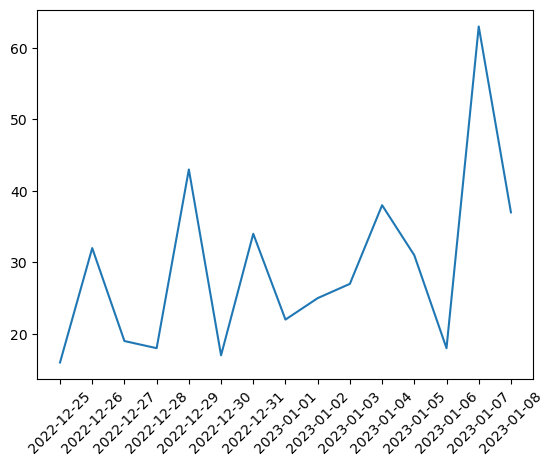

In [15]:
tweets_count = tickers_tweets_users_fact.join(tweets_dim, ['tweet_id']).where(col('ticker') == ticker).\
        withColumn('date',date_format(col('created_at'),"yyyy-MM-dd")).\
        groupBy('date').count().orderBy(col('date').asc())
tweets_count.show()
tweets_count_df = tweets_count.toPandas()
plt.plot(tweets_count_df['date'],tweets_count_df['count'])
plt.xticks(rotation = 45)

### Information regarding the ticker

In [16]:
tickers_info_dim_path = os.path.join(DL_BUCKET_OUTPUT_PREFIX,'tickers_info_dim/tickers_info_dim.parquet').replace('s3','s3a')

In [17]:
tickers_info_dim=spark.read.parquet(tickers_info_dim_path)
ticker_info = tickers_info_dim.where(col('ticker') == ticker)
ticker_info.distinct().toPandas()

,ticker,industry,zip,currency,isin,exchange,fullTimeEmployees,fundFamily,fundInceptionDate,isEsgPopulated,lastFiscalYearEnd,lastSplitDate,lastSplitFactor,longBusinessSummary,longName,marketCap,mostRecentQuarter,nextFiscalYearEnd,numberOfAnalystOpinions,quoteType,shortName,startDate,uuid,percentage_of_shares_held_by_all_insider,percentage_of_shares_held_by_institutions,percentage_of_float_held_by_institutions,number_of_institutions_holding_shares
0,MMM,Conglomerates,55144-1000,USD,None,NYQ,95000,None,None,false,1640908800,1064880000,2:1,"3M Company operates as a diversified technology company worldwide. It operates through four segments: Safety and Industrial; Transportation and Electronics; Health Care; and Consumer. The Safety and Industrial segment offers industrial abrasives and finishing for metalworking applications; autobody repair solutions; closure systems for personal hygiene products, masking, and packaging materials; electrical products and materials for construction and maintenance, power distribution, and electrical original equipment manufacturers; structural adhesives and tapes; respiratory, hearing, eye, and fall protection solutions; and natural and color-coated mineral granules for shingles. The Transportation and Electronics segment provides ceramic solutions; attachment tapes, films, sound, and temperature management for transportation vehicles; premium large format graphic films for advertising and fleet signage; light management films and electronics assembly solutions; packaging and interconnection solutions; and reflective signage for highway, and vehicle safety. The Healthcare segment offers food safety indicator solutions; health care procedure coding and reimbursement software; skin, wound care, and infection prevention products and solutions; dentistry and orthodontia solutions; and filtration and purification systems. The Consumer segment provides consumer bandages, braces, supports and consumer respirators; cleaning products for the home; retail abrasives, paint accessories, car care DIY products, picture hanging, and consumer air quality solutions; and stationery products. It offers its products through e-commerce and traditional wholesalers, retailers, jobbers, distributors, and dealers. The company was founded in 1902 and is based in St. Paul, Minnesota.",3M Company,66284937216,1664496000,1703980800,17,EQUITY,3M Company,None,None,0.12,68.01,68.09,2582


### daily historical prices of the ticker

In [21]:
tickers_historical_prices_fact_path =  os.path.join(DL_BUCKET_OUTPUT_PREFIX,'tickers_historical_prices_fact/tickers_historical_prices_fact.parquet').replace('s3','s3a')

In [29]:
tickers_historical_prices_fact = spark.read.parquet(tickers_historical_prices_fact_path)
ticker_historical_prices_1d = tickers_historical_prices_fact.where((col('ticker') == ticker) & (col('interval') == '1d'))
ticker_historical_prices_1d = ticker_historical_prices_1d.toPandas().sort_values(by= 'date', ascending = False)[:10]

In [36]:
ticker_historical_prices_1d = ticker_historical_prices_1d.query("ticker == 'MMM'").sort_values(by = ['date'],ascending = True)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, '2022-12-22'),
  Text(1, 0, '2022-12-23'),
  Text(2, 0, '2022-12-27'),
  Text(3, 0, '2022-12-28'),
  Text(4, 0, '2022-12-29'),
  Text(5, 0, '2022-12-30'),
  Text(6, 0, '2023-01-03'),
  Text(7, 0, '2023-01-04'),
  Text(8, 0, '2023-01-05'),
  Text(9, 0, '2023-01-06')])

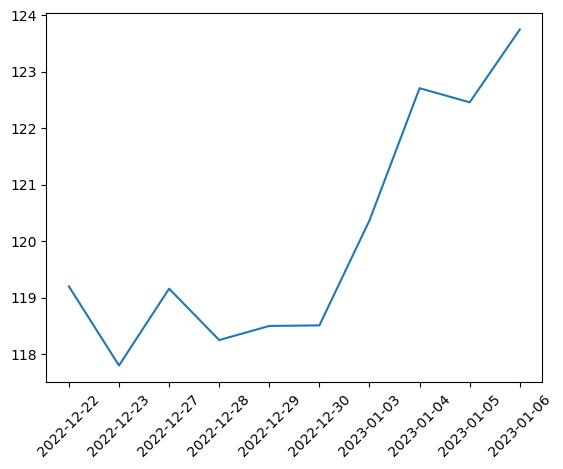

In [39]:
plt.plot(ticker_historical_prices_1d['date'],ticker_historical_prices_1d['low'])
plt.xticks(rotation=45)

### hourly historical prices of the ticker

In [40]:
tickers_historical_prices_fact = spark.read.parquet(tickers_historical_prices_fact_path)
ticker_historical_prices_1h = tickers_historical_prices_fact.where((col('ticker') == ticker) & (col('interval') == '1h'))
ticker_historical_prices_1h = ticker_historical_prices_1h.toPandas().sort_values(by= ['date','datetime'], ascending = [True,True])

In [46]:
ticker_historical_prices_1h = ticker_historical_prices_1h.query("date >= '2022-12-25'")

<AxesSubplot: xlabel='datetime'>

(array([-20.,   0.,  20.,  40.,  60.,  80., 100., 120., 140.]),
 [Text(-20.0, 0, '2023-01-05 17:00:00'),
  Text(0.0, 0, '2022-12-27 04:00:00'),
  Text(20.0, 0, '2022-12-28 08:00:00'),
  Text(40.0, 0, '2022-12-29 11:30:00'),
  Text(60.0, 0, '2022-12-30 15:30:00'),
  Text(80.0, 0, '2023-01-03 18:00:00'),
  Text(100.0, 0, '2023-01-05 05:00:00'),
  Text(120.0, 0, '2023-01-06 08:00:00'),
  Text(140.0, 0, '')])

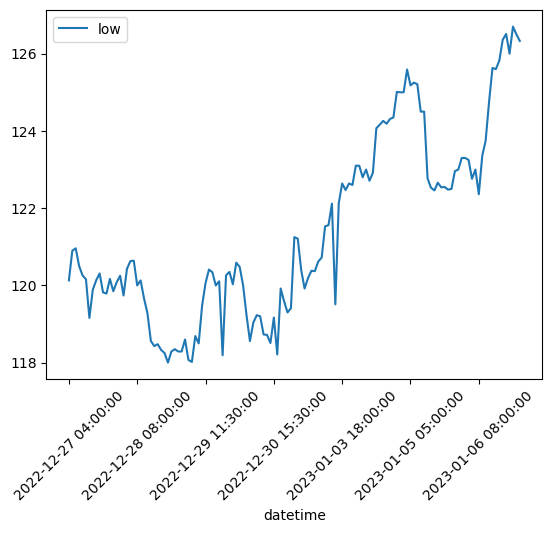

In [51]:
ticker_historical_prices_1h.plot.line(x='datetime', y='low') 
plt.xticks(rotation=45)

### historical prices per minute of the ticker

In [52]:
tickers_historical_prices_fact = spark.read.parquet(tickers_historical_prices_fact_path)
ticker_historical_prices_1m = tickers_historical_prices_fact.where((col('ticker') == ticker) & (col('interval') == '1m'))
ticker_historical_prices_1m = ticker_historical_prices_1m.toPandas().sort_values(by= 'datetime', ascending = True)

In [53]:
ticker_historical_prices_1m = ticker_historical_prices_1m.query("date >= '2022-12-25'")

<AxesSubplot: xlabel='datetime'>

(array([-500.,    0.,  500., 1000., 1500., 2000., 2500., 3000., 3500.,
        4000., 4500.]),
 [Text(-500.0, 0, '2023-01-05 17:21:00'),
  Text(0.0, 0, '2022-12-27 04:00:00'),
  Text(500.0, 0, '2022-12-28 06:08:00'),
  Text(1000.0, 0, '2022-12-29 08:17:00'),
  Text(1500.0, 0, '2022-12-30 09:40:00'),
  Text(2000.0, 0, '2023-01-03 09:07:00'),
  Text(2500.0, 0, '2023-01-04 09:49:00'),
  Text(3000.0, 0, '2023-01-05 10:13:00'),
  Text(3500.0, 0, '2023-01-06 10:32:00'),
  Text(4000.0, 0, ''),
  Text(4500.0, 0, '')])

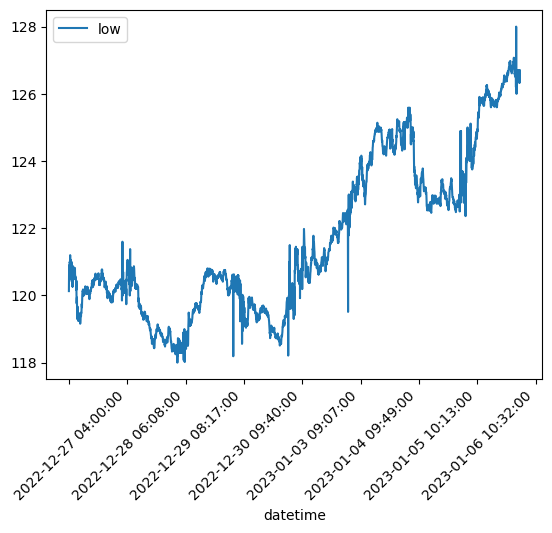

In [55]:
ticker_historical_prices_1m.plot.line(x='datetime', y='low') 
plt.xticks(rotation=45)

### News regarding the ticker

In [58]:
ticker_news_fact_path =  os.path.join(DL_BUCKET_OUTPUT_PREFIX,'tickers_news_fact/tickers_news_fact.parquet').replace('s3','s3a')

In [59]:
ticker_news_fact = spark.read.parquet(ticker_news_fact_path)
ticker_news_fact.count()
ticker_news_fact.show(2)

27

+--------------------+------+
|                uuid|ticker|
+--------------------+------+
|c28a557a-9379-3f3...|   MMM|
|7dce208d-5ede-3bc...|   MMM|
+--------------------+------+
only showing top 2 rows



In [60]:
news_dim_path =  os.path.join(DL_BUCKET_OUTPUT_PREFIX,'news_dim/news_dim.parquet').replace('s3','s3a')

In [61]:
news_dim = spark.read.parquet(news_dim_path)
news_dim.count()
news_dim.show(2)

27

+--------------------+--------------------+-----------+--------------------+---------------------+-----+
|                uuid|               title|  publisher|                link|provider_publish_time| type|
+--------------------+--------------------+-----------+--------------------+---------------------+-----+
|f45dfb94-5cec-3fd...|3M's Litigation C...|   Benzinga|https://finance.y...|           1672161157|STORY|
|9d44e6b3-9c5e-366...|Down Between 29% ...|Motley Fool|https://finance.y...|           1669042380|STORY|
+--------------------+--------------------+-----------+--------------------+---------------------+-----+
only showing top 2 rows



In [64]:
news = ticker_news_fact.join(news_dim, ['uuid']).where(col('ticker') == ticker).toPandas()

In [73]:
news['provider_publish_time'] = news['provider_publish_time'].astype('int64')

In [66]:
from datetime import datetime

In [74]:
news['provider_publish_time'] = news.apply(lambda x : datetime.fromtimestamp(x['provider_publish_time']), axis = 1)

In [76]:
news.sort_values(by = ["provider_publish_time"], ascending = False)

,uuid,ticker,title,publisher,link,provider_publish_time,type
4,05aa2b93-d7d5-326b-a1a8-17efd912f407,MMM,These 3 Dow Stocks Are Set to Soar in 2023 and Beyond,Motley Fool,https://finance.yahoo.com/m/05aa2b93-d7d5-326b-a1a8-17efd912f407/these-3-dow-stocks-are-set-to.html,2023-01-07 12:35:00,STORY
3,3d574464-7913-37ec-9c95-4a1a30894c7f,MMM,"3M Innovation on Full Display at CES, the World’s Largest Annual Tech Event",ACCESSWIRE,https://finance.yahoo.com/news/3m-innovation-full-display-ces-141500180.html,2023-01-06 14:15:00,STORY
7,2929d4ce-9875-3326-914c-bcf1b4e265b3,MMM,Don't Overlook These 3 Powerhouse Stocks in 2023,Motley Fool,https://finance.yahoo.com/m/2929d4ce-9875-3326-914c-bcf1b4e265b3/don%27t-overlook-these-3.html,2023-01-06 13:00:00,STORY
12,7dce208d-5ede-3bcd-a6b0-17f5784af269,MMM,3M (MMM) Dips More Than Broader Markets: What You Should Know,Zacks,https://finance.yahoo.com/news/3m-mmm-dips-more-broader-225010037.html,2023-01-05 22:50:10,STORY
2,c208c4a5-fd52-3ef5-b9c1-2500d6f0dac4,MMM,"2023 People to Watch: Mike Roman, CEO of 3M",American City Business Journals,https://finance.yahoo.com/m/c208c4a5-fd52-3ef5-b9c1-2500d6f0dac4/2023-people-to-watch%3A-mike.html,2023-01-05 19:37:39,STORY
6,9ed37f2f-befa-3c74-8e8b-22d01bdc7d1b,MMM,2 Stocks Down 52% and 81% to Buy Right Now,Motley Fool,https://finance.yahoo.com/m/9ed37f2f-befa-3c74-8e8b-22d01bdc7d1b/2-stocks-down-52%25-and-81%25-to.html,2023-01-05 11:28:00,STORY
11,fa050738-a5d3-3663-9021-f6a62096957c,MMM,Analyst Report: 3M Company,Morningstar Research,https://finance.yahoo.com/m/fa050738-a5d3-3663-9021-f6a62096957c/analyst-report%3A-3m-company.html,2023-01-04 03:34:52,STORY
9,c5baeb7a-7c38-36ca-930e-11e92606ef23,MMM,3 Top U.S. Stocks to Watch in January,Motley Fool,https://finance.yahoo.com/m/c5baeb7a-7c38-36ca-930e-11e92606ef23/3-top-u.s.-stocks-to-watch-in.html,2023-01-03 15:07:00,STORY
1,16ef33f8-887c-3512-88e4-6b2c335d5850,MMM,"3M Tries to Contain Legal Battles Over ‘Forever Chemicals,’ Earplugs",The Wall Street Journal,https://finance.yahoo.com/m/16ef33f8-887c-3512-88e4-6b2c335d5850/3m-tries-to-contain-legal.html,2023-01-03 14:00:00,STORY
16,ba738361-ac21-3354-839e-c9c291afd33c,MMM,11 Best Stocks to Buy for Deflation,Insider Monkey,https://finance.yahoo.com/news/11-best-stocks-buy-deflation-190606188.html,2022-12-29 19:06:06,STORY
